# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

### Inspecting the azdias dataset

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Comment
<span style="color:blue">In this case by visual inspection I see some NaN values in some columns (PLZ8_ANTG1,	PLZ8_ANTG2,	PLZ8_ANTG3,	PLZ8_ANTG4,	PLZ8_BAUMAX,	PLZ8_HHZ,	PLZ8_GBZ,	ARBEIT,	ORTSGR_KLS9,	RELAT_AB). This means that the dataset azdias may contain more of these NaNs values. In the next cells I will find how many of them are NaNs</span>

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
# We check the shape
azdias.shape

(891221, 85)

In [6]:
# We review the type of information per column
df_plot = azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [7]:
# Detecting the NaN values by column in the dataset azdias

azdias_nan_values = azdias.isnull().sum()
df_plot = azdias_nan_values

pd.DataFrame({'Attribute':df_plot.index,
              'missing_values':df_plot.values}).sort_values(by=['missing_values'], ascending=False)

,Attribute,missing_values
47,KK_KUNDENTYP,584612
65,KBA05_GBZ,133324
60,KBA05_ANTG1,133324
62,KBA05_ANTG3,133324
71,MOBI_REGIO,133324
...,...,...
35,SEMIO_KAEM,0
36,SEMIO_PFLICHT,0
37,SEMIO_TRADV,0
38,SHOPPER_TYP,0


In [8]:
# Print the amount of NaNs values in the dataset and measure the proportion with respect all the values

azdias_nan_sum = azdias_nan_values.sum()
azdias_all_sum = azdias.sum().sum()

print("There are ", azdias_nan_sum, " NaNs values in ", azdias_all_sum, " values. Which represents the ",
      azdias_nan_sum/azdias_all_sum*100, "%" )

There are  4896838  NaNs values in  3281221885.0  values. Which represents the  0.14923824634919503 %


/var/folders/g5/ky6bmjt90kqbsypch2rdmgf00000gp/T/ipykernel_72226/2151755526.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  azdias_all_sum = azdias.sum().sum()


### Analyzing feat_info dataset

In [9]:
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Comment
<span style="color:blue">The dataset feat_info seems also to have null values in the shape [] without any value. I will need to identify later how many of these empty values exists and clean them up or convert them to NaN values</span>

In [10]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [11]:
feat_info.shape

(85, 4)

In [12]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [13]:
# Inspecting for NaN or Null values or [] 
feat_info_all_sum = feat_info.sum().sum()
feat_info_all_sum

'AGER_TYPALTERSKATEGORIE_GROBANREDE_KZCJT_GESAMTTYPFINANZ_MINIMALISTFINANZ_SPARERFINANZ_VORSORGERFINANZ_ANLEGERFINANZ_UNAUFFAELLIGERFINANZ_HAUSBAUERFINANZTYPGEBURTSJAHRGFK_URLAUBERTYPGREEN_AVANTGARDEHEALTH_TYPLP_LEBENSPHASE_FEINLP_LEBENSPHASE_GROBLP_FAMILIE_FEINLP_FAMILIE_GROBLP_STATUS_FEINLP_STATUS_GROBNATIONALITAET_KZPRAEGENDE_JUGENDJAHRERETOURTYP_BK_SSEMIO_SOZSEMIO_FAMSEMIO_RELSEMIO_MATSEMIO_VERTSEMIO_LUSTSEMIO_ERLSEMIO_KULTSEMIO_RATSEMIO_KRITSEMIO_DOMSEMIO_KAEMSEMIO_PFLICHTSEMIO_TRADVSHOPPER_TYPSOHO_KZTITEL_KZVERS_TYPZABEOTYPALTER_HHANZ_PERSONENANZ_TITELHH_EINKOMMEN_SCOREKK_KUNDENTYPW_KEIT_KIND_HHWOHNDAUER_2008ANZ_HAUSHALTE_AKTIVANZ_HH_TITELGEBAEUDETYPKONSUMNAEHEMIN_GEBAEUDEJAHROST_WEST_KZWOHNLAGECAMEO_DEUG_2015CAMEO_DEU_2015CAMEO_INTL_2015KBA05_ANTG1KBA05_ANTG2KBA05_ANTG3KBA05_ANTG4KBA05_BAUMAXKBA05_GBZBALLRAUMEWDICHTEINNENSTADTGEBAEUDETYP_RASTERKKKMOBI_REGIOONLINE_AFFINITAETREGIOTYPKBA13_ANZAHL_PKWPLZ8_ANTG1PLZ8_ANTG2PLZ8_ANTG3PLZ8_ANTG4PLZ8_BAUMAXPLZ8_HHZPLZ8_GBZARBEITORTSGR_KLS

#### Comment
<span style="color:blue">In this dataset the null values are the values in the column "missing_or_unknown" as "[]", I will proceed to count them</span>

In [14]:
feat_info_null_values_num = len(feat_info[feat_info['missing_or_unknown']=='[]'])

print("There are ", feat_info_null_values_num, " null values out of ", len(feat_info), ". Which represents the",
      feat_info_null_values_num/len(feat_info)*100, "%" )

There are  10  null values out of  85 . Which represents the 11.76470588235294 %


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### Deeper analysis on feat_info dataset

<span style="color:blue">Based on the visual inspection in the Step 0, the dataset feat_info has some empty values as "[]". In addition, the values are also represented with a maximum of 3 elements in the list. For example: [-1,0]. The strategy here would be to get these values in different columns in order to create a more structured dataset.</span>



In [15]:
# Identify missing or unknown data values and convert them to NaNs. 
# I will strip the data and separate the values in columns

feat_info_cleaned = feat_info.copy()
# This will remove the symbols [ and ]
feat_info_cleaned["missing_or_unknown"] = feat_info["missing_or_unknown"].str.strip('[').str.strip(']')
# Separate the values by commas and add them in new columns
feat_info_cleaned[['value_one', 'value_two', 'value_three']] = feat_info_cleaned["missing_or_unknown"].str.split(',', expand=True)
# Show the first 10 rows
feat_info_cleaned.tail(40)

,attribute,information_level,type,missing_or_unknown,value_one,value_two,value_three
45,ANZ_TITEL,household,numeric,,,None,None
46,HH_EINKOMMEN_SCORE,household,ordinal,"-1,0",-1,0,None
47,KK_KUNDENTYP,household,categorical,-1,-1,None,None
48,W_KEIT_KIND_HH,household,ordinal,"-1,0",-1,0,None
49,WOHNDAUER_2008,household,ordinal,"-1,0",-1,0,None
50,ANZ_HAUSHALTE_AKTIV,building,numeric,0,0,None,None
51,ANZ_HH_TITEL,building,numeric,,,None,None
52,GEBAEUDETYP,building,categorical,"-1,0",-1,0,None
53,KONSUMNAEHE,building,ordinal,,,None,None
54,MIN_GEBAEUDEJAHR,building,numeric,0,0,None,None


### Comment

<span style="color:blue">In this view we need to find the attributes that do not have any relevant numerical value. There may be some cases in which all the values across all the value columns (value_one, value_two, value_three) are None or empty. The way to find them is by filtering the columns by None or by converting in float.
    
We need to find these attributes in order to see which values we will not be able to map and discard from the azdias dataset.</span>

In [16]:
for index, row in feat_info_cleaned.iterrows():
    if len(row['value_one']) == 0 and row['value_two'] == None and row['value_three'] == None:
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
    
    elif row['value_one'] == 'X' and row['value_two'] == None and row['value_three'] == None:
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
    
    elif row['value_one'] == 'XX' and row['value_two'] == None and row['value_three'] == None:
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
        
    elif row['value_one'] and row['value_two'] == 'X' and row['value_three'] == None:
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
    
    elif row['value_one'] and row['value_two'] == 'XX' and row['value_three'] == None:
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
        
    elif row['value_one'] and row['value_two'] == None and row['value_three'] == 'X':
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])
    
    elif row['value_one'] and row['value_two'] == None and row['value_three'] == 'XX':
        print(row['attribute'],row['type'],row['value_one'], row['value_two'], row['value_three'])

GFK_URLAUBERTYP categorical  None None
GREEN_AVANTGARDE categorical  None None
ANZ_PERSONEN numeric  None None
ANZ_TITEL numeric  None None
ANZ_HH_TITEL numeric  None None
KONSUMNAEHE ordinal  None None
CAMEO_DEUG_2015 categorical -1 X None
CAMEO_DEU_2015 categorical XX None None
CAMEO_INTL_2015 mixed -1 XX None
GEBAEUDETYP_RASTER ordinal  None None
MOBI_REGIO ordinal  None None
ONLINE_AFFINITAET ordinal  None None
KBA13_ANZAHL_PKW numeric  None None


### Comment

<span style="color:blue">Analysing the incomplete columns, there are around 10 attributes that are empty and do not have a mapping in the main dataset and 4 numerical values without mappings. Although, it is too early to determine if these columns will be dropped from the main dataset. It gives some data insights of the values to be mapped.
</span>

### azdias dataset conversion

In [17]:
# Considering our previous analysis:

print("There are ", azdias_nan_sum, " NaNs values in ", azdias_all_sum, " values. Which represents the ",
      azdias_nan_sum/azdias_all_sum*100, "%" )

There are  4896838  NaNs values in  3281221885.0  values. Which represents the  0.14923824634919503 %


In [18]:
# We proceed now for the conversion 

for indx in range(len(feat_info_cleaned)):
    missing_or_unknown = feat_info_cleaned.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info_cleaned.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [19]:
azdias_nan_sum_new = azdias.isnull().sum().sum()

print("After replacing the new amount of empty values added in the azdias dataset is ",azdias_nan_sum_new - azdias_nan_sum  )

print("Therefore, there are ", azdias_nan_sum_new, " missing values after replacing conversion.")
print("Which represents the ", azdias_nan_sum_new/azdias_all_sum*100, "%", " of", azdias_all_sum, " records")

After replacing the new amount of empty values added in the azdias dataset is  3477091
Therefore, there are  8373929  missing values after replacing conversion.
Which represents the  0.2552076419543935 %  of 3281221885.0  records


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_replaced_sum = azdias.isnull().sum()
pd.DataFrame({'Attribute':azdias_replaced_sum.index,
              'missing_values':azdias_replaced_sum.values}).sort_values(by=['missing_values'], ascending=False)

,Attribute,missing_values
40,TITEL_KZ,889061
0,AGER_TYP,685843
47,KK_KUNDENTYP,584612
64,KBA05_BAUMAX,476524
11,GEBURTSJAHR,392318
...,...,...
32,SEMIO_RAT,0
33,SEMIO_KRIT,0
34,SEMIO_DOM,0
37,SEMIO_TRADV,0


Text(0.5, 0, 'Number of Columns (Attributes)')

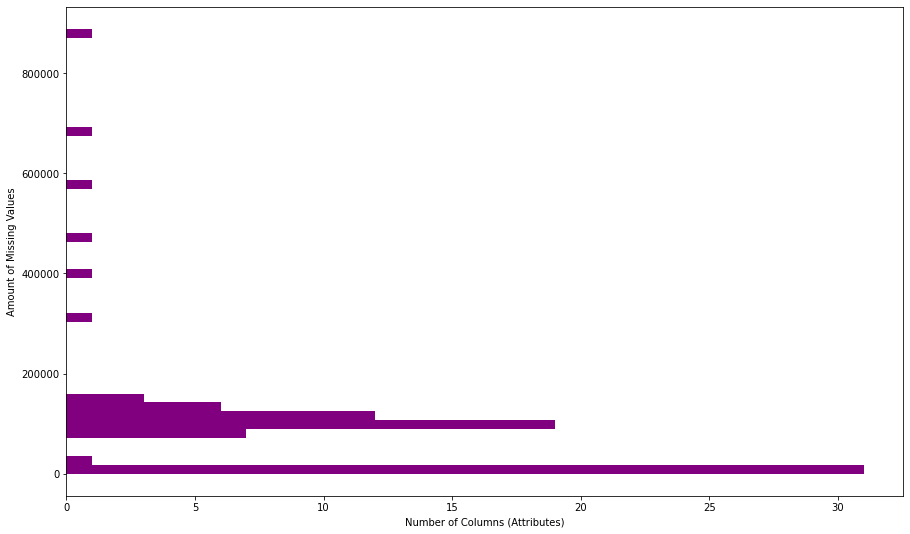

In [21]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(15,9))
plt.hist(azdias_replaced_sum, color='purple', orientation='horizontal', bins=50)
plt.ylabel('Amount of Missing Values')
plt.xlabel('Number of Columns (Attributes)')

In [22]:
df_plot = azdias_replaced_sum.describe()
pd.DataFrame({'Stats':df_plot.index,
              'values':df_plot.values}).transpose()

,0,1,2,3,4,5,6,7
Stats,count,mean,std,min,25%,50%,75%,max
values,85.0,98516.811765,146604.203317,0.0,0.0,93148.0,116515.0,889061.0


### Comment

<span style="color:blue">As we can see in the image there are few columns that have more than 200000 missing values. One of the columns hits 889061 missing values from 891221, then that is around 99.75% or missing data in that column.  As a consequence that and similar columns do not offer relevant information. Based on the histogram we can establish a threshold to eliminate the first columns with hig amount of missing values.
</span>

In [23]:
# Get the colums to remove
no_information_columns = azdias_replaced_sum[azdias_replaced_sum > 200000].index
list(no_information_columns)

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

### Comment

<span style="color:blue">The first columns that were deleted based on the high amount (>200000) of missing values are: AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'
</span>

In [24]:
# I make a security copy
azdias_clean = azdias.copy()
# Proceed to drop the columns
azdias_clean.drop(no_information_columns, axis=1, inplace=True)
azdias_clean.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [25]:
# The shape of the dataset is now
print("The dataset has", azdias_clean.shape[0], " and ", azdias_clean.shape[1], "attributes")

The dataset has 891221  and  79 attributes


In [26]:
azdias_clean_isnull = azdias_clean.isnull()

Text(0.5, 0, 'Number of Columns (Attributes)')

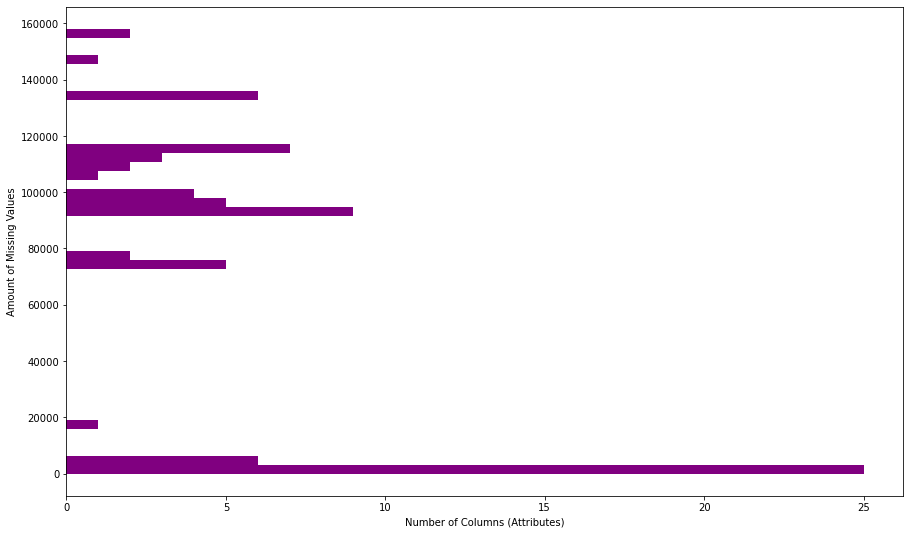

In [27]:
# Now we see still some null values after the first cleaning
plt.figure(figsize=(15,9))
plt.hist(azdias_clean_isnull.sum(), color='purple', orientation='horizontal', bins=50)
plt.ylabel('Amount of Missing Values')
plt.xlabel('Number of Columns (Attributes)')

### Comment

<span style="color:blue">Based on the plot, we can still see a big amount of missing values. However, we can perhaps consider to clean columns with over 200000 missing values as a rule of thumb.
</span>

<AxesSubplot:>

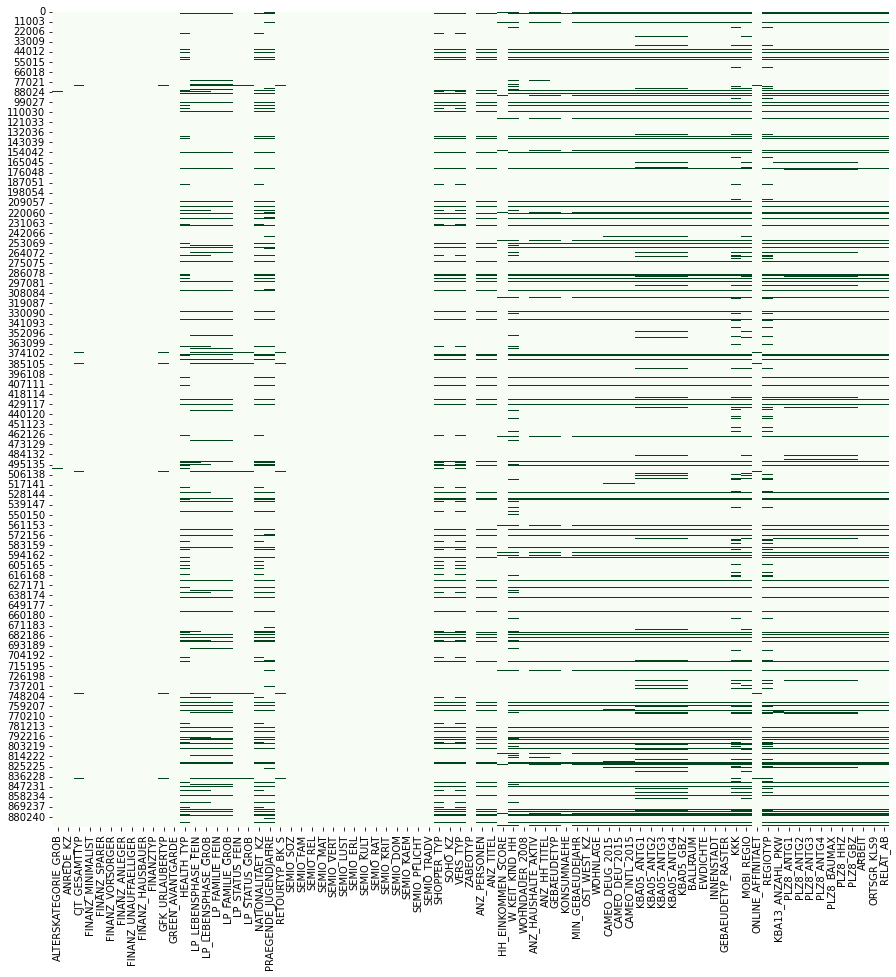

In [28]:
# Much more detailes analysis on missing values per row in the dataset.

plt.figure(figsize=(15,15))
# sns.heatmap(azdias_clean_isnull, cmap='Greens', cbar=False, annot=True, fmt="d")
sns.heatmap(azdias_clean_isnull, cmap='Greens', cbar=False)

### Comment

<span style="color:blue">The previous heatmap shows in green tones the amount of missing values per row. The stronger the colour, the higher the amount of missing value sin that attribute exist. There are columns that preserve completeness such as SEMIO_FAM but otherones as NATIONALITAET KZ that have nationality values some values are leaved empty.
</span>

#### Discussion 1.1.2: Assess Missing Data in Each Column


<span style="color:blue">The previous heatmap shows in green tones the amount of missing values. The stronger the colour, the higher the amount of missing values in that attribute exist. This just reveals that I still need to perform more cleaning in the dataset. However, we can still visually appreciate that there is an ammount of users who have all the attributes completed and these one will play a main role to identify the clusters in a later stage. Nevertheless, we need still to evaluate which attributes we can still discard based on discovery the missing data proportion by column in the next section.
</span>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?

df_azdias_count_missing_rows = azdias_clean_isnull.sum(axis=1)

df = pd.DataFrame(df_azdias_count_missing_rows)
df.columns = ['missing_values']
df.transpose()


,0,1,2,3,4,5,6,7,8,9,...,891211,891212,891213,891214,891215,891216,891217,891218,891219,891220
missing_values,43,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,3,4,5,0,0


In [30]:
df_plot = df_azdias_count_missing_rows.describe()

pd.DataFrame({'Stats':df_plot.index,
              'values':df_plot.values})

,Stats,values
0,count,891221.000000
1,mean,5.649894
2,std,13.234687
3,min,0.000000
4,25%,0.000000
5,50%,0.000000
6,75%,3.000000
7,max,49.000000


In [31]:
print("The dataset has", str(len(azdias_clean_isnull.columns)), "columns")

The dataset has 79 columns


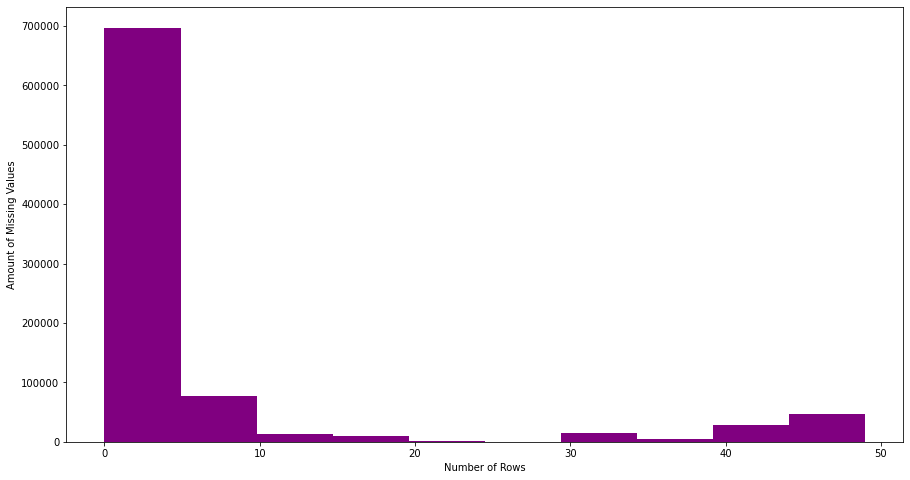

In [32]:
# Graphical representation in a histogram
ax = plt.figure(figsize=(15,8))
ax = df_azdias_count_missing_rows.plot(grid=False, kind='hist', color='purple')
ax = plt.ylabel('Amount of Missing Values')
ax = plt.xlabel('Number of Rows')

### Comment

<span style="color:blue">Combining the description of the dataset and the histogram, it is possible to notice that the 50% of the rows in the dataset are complete, which is already a great number and 75% has at least 3 missing values with an edge row that has 49 missing values out of 79.
</span>

<span style="color:blue"> A good strategy to divide the data in two subsets: complete and not complete rows. A typical strategy is to add an additional column to the dataset to label each row.
</span>

In [33]:
azdias_clean['complete'] = azdias_clean_isnull.sum(axis=1) == 0

azdias_complete_rows = azdias_clean.copy()
azdias_complete_rows = azdias_complete_rows[azdias_complete_rows.complete==True]

azdias_incomplete_rows = azdias_clean.copy()
azdias_incomplete_rows = azdias_incomplete_rows[azdias_incomplete_rows.complete==False]

In [34]:
print('The total amount of complete rows is ', len(azdias_complete_rows), 'and incomplete rows', len(azdias_incomplete_rows), 'This represents a ', len(azdias_complete_rows)/len(azdias_clean), "% of complete rows" )

The total amount of complete rows is  623209 and incomplete rows 268012 This represents a  0.6992754883468859 % of complete rows


### Comment

<span style="color:blue"> Having arount 70% of complete data is significant to proceed with a good clustering analysis. Based on my intuition with 70% of complete data, we can fairly eliminate all the rows that are not complete to continue the analysis. However, I will plot the distribution of missing values in some plots to verify this assumption. </span>

In [102]:
low_missing_values_columns = azdias_replaced_sum[azdias_replaced_sum < 5000]
low_missing_values_columns



ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP          4854
GREEN_AVANTGARDE            0
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
ONLINE_AFFINITAET        4854
dtype: int64

In [103]:
df = pd.DataFrame(low_missing_values_columns)
df.columns = ['missing_values']
df.transpose()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ZABEOTYP,ONLINE_AFFINITAET
missing_values,2881,0,4854,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4854


In [36]:
# We select 5 columns
sample_columns = np.random.choice(low_missing_values_columns.index, 5)
# We get only these columns from the dataset
sample_columns_list = list(sample_columns)
sample_columns_list.append('complete')
azdias_clean[sample_columns_list].head(10)

,FINANZTYP,GFK_URLAUBERTYP,SEMIO_REL,SEMIO_REL,SEMIO_ERL,complete
0,4,10.0,7,7,3,False
1,1,10.0,4,4,2,True
2,1,10.0,3,3,6,True
3,6,1.0,2,2,7,False
4,5,5.0,4,4,4,True
5,2,1.0,7,7,2,True
6,4,12.0,5,5,5,True
7,5,9.0,7,7,2,True
8,6,3.0,4,4,4,True
9,1,12.0,1,1,6,True


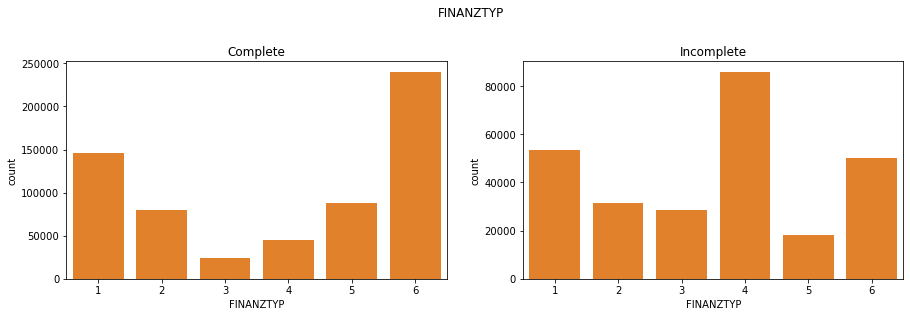

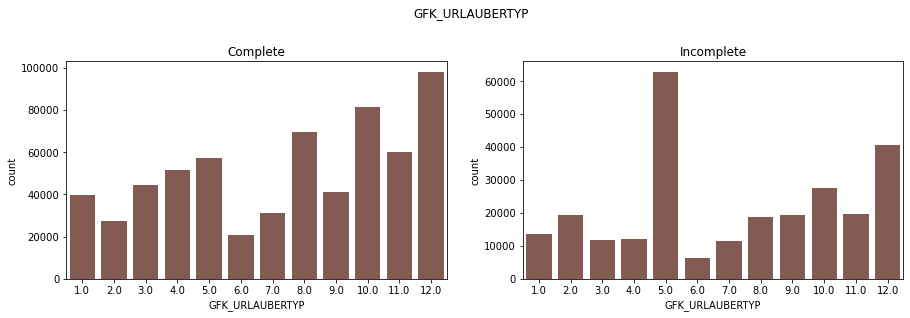

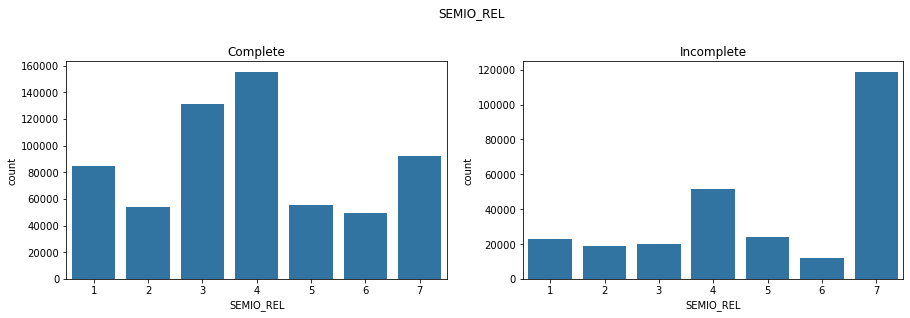

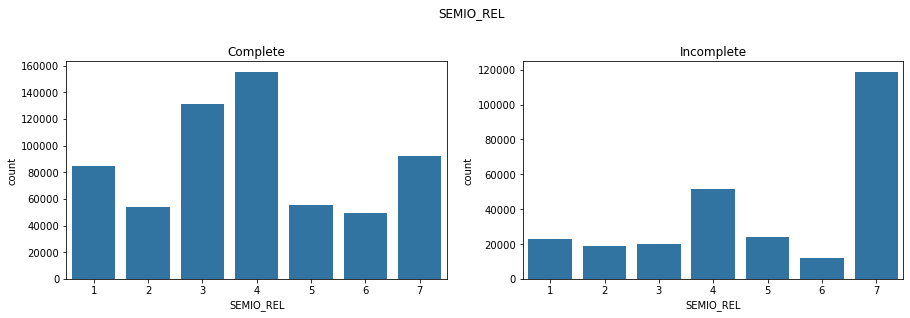

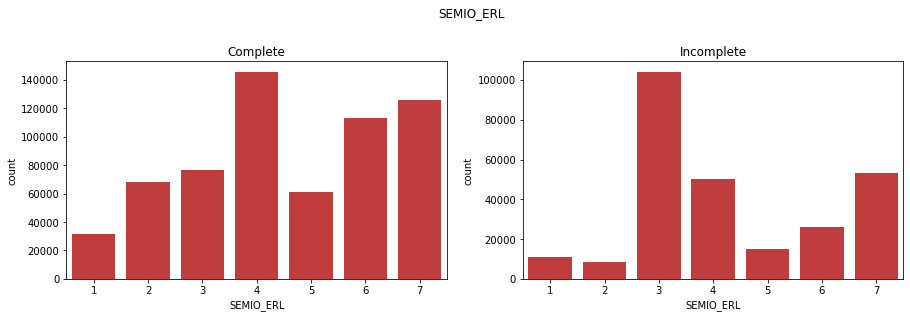

In [37]:
import random

def plot_comparison(data, selected_col):
    complete = azdias_complete_rows[azdias_complete_rows.complete==True]
    incomplete = azdias_incomplete_rows[azdias_incomplete_rows.complete==False]
    
    selected_color = sns.color_palette()[random.randint(0,5)]
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=selected_col, data=complete, color=selected_color)
    plt.title('Complete')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=selected_col, data=incomplete, color=selected_color)
    plt.title('Incomplete')
    
    plt.suptitle(selected_col, y=1.07)
    
for column in sample_columns:
    plot_comparison(azdias_clean, column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

<span style="color:blue"> Inspecting the distribution of values, there is a qualitative difference. As a consequence the missing values will introduce noise when we will try to apply the clustering. Then we will have the chance to get some bias. Previously by analyzing the complete rows, we saw that removing the columns (attributes) with more than 200000 missing values was a decision to take in order to keep with fewer missing values. However, in this pre-cleaned dataset the remaining missing values now represent the 30% of the cleaned dataset. As a consequence 70% are complete rows and if we continue the analysis based on them. We can get better results during the clustering. The next stept that I will assume is to keep only the dataset with complete rows.
</span>




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?
df_plot = feat_info_cleaned.type.value_counts()

pd.DataFrame({'Feature Type':df_plot.index,
              'values':df_plot.values})


,Feature Type,values
0,ordinal,49
1,categorical,21
2,numeric,7
3,mixed,7
4,interval,1


### Comment

<span style="color:blue"> In this case there are 21 categorical and 7 mixed types to analyse. The rest can be kept without changes </span>

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Drop columns
feat_info_cleaned = feat_info_cleaned[~feat_info_cleaned.attribute.isin(no_information_columns)]

# Get categorical columns
categorical_columns = feat_info_cleaned.query('type == "categorical"').attribute
print('Categorical features:', len(categorical_columns))

# Find binary columns
binary_columns = []
for col in categorical_columns:
    value_count = azdias_complete_rows[col].value_counts()
    if len(value_count) ==2:
        binary_columns.append(col)
print('Binary features:', len(binary_columns))

Categorical features: 18
Binary features: 5


### Comment

<span style="color:blue"> We can now proceed to see which of these Categorical features or Binary features need to be re-encode or transform </span>

### Review Binary Columns

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.
for col in binary_columns:
    print(azdias_complete_rows[col].value_counts())

2    318591
1    304618
Name: ANREDE_KZ, dtype: int64
0    476988
1    146221
Name: GREEN_AVANTGARDE, dtype: int64
0.0    617913
1.0      5296
Name: SOHO_KZ, dtype: int64
2.0    331723
1.0    291486
Name: VERS_TYP, dtype: int64
W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64


In [41]:
# Only VERS_TYP needs to be re-encode
recode = {'O': 0, 'W': 1}
azdias_complete_rows.replace({'OST_WEST_KZ': recode}, inplace=True)

### Review  Multi-Level Categoricals

In [42]:
for col in categorical_columns:
    if col not in binary_columns:
        print(azdias_complete_rows[col].value_counts(), "Total--> ", azdias_complete_rows[col].value_counts().sum())

4.0    160908
3.0    119004
2.0    113203
5.0     79854
6.0     77273
1.0     72967
Name: CJT_GESAMTTYP, dtype: int64 Total-->  623209
6    240292
1    146234
5     88119
2     79302
4     44630
3     24632
Name: FINANZTYP, dtype: int64 Total-->  623209
12.0    98076
10.0    81624
8.0     69405
11.0    60164
5.0     57326
4.0     51615
3.0     44233
9.0     41272
1.0     39929
7.0     31423
2.0     27430
6.0     20712
Name: GFK_URLAUBERTYP, dtype: int64 Total-->  623209
1.0     325104
10.0    108290
2.0      80801
11.0     41248
8.0      16764
7.0      14077
4.0       9174
5.0       9123
9.0       8831
6.0       6211
3.0       3586
Name: LP_FAMILIE_FEIN, dtype: int64 Total-->  623209
1.0    325104
5.0    158369
2.0     80801
4.0     37052
3.0     21883
Name: LP_FAMILIE_GROB, dtype: int64 Total-->  623209
1.0     175564
9.0      97350
10.0     93471
2.0      81016
3.0      58334
4.0      58008
6.0      23303
5.0      17870
8.0      10742
7.0       7551
Name: LP_STATUS_FEIN, dtype: int64

### Proceed to drop columns, list of categories and attribute mappings

In [43]:
# Drop Columns
drop_columns = ['SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP','LP_STATUS_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'FINANZTYP']
azdias_complete_rows.drop(drop_columns, axis=1, inplace=True)


## Re-encode categorical variable(s) to be kept in the analysis.
# Define categorical columns
keep_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']

# Create a dataframe for categorical and non-categorical columns
azdias_categorical = azdias_complete_rows[keep_columns]
azdias_non_categorical = azdias_complete_rows.drop(keep_columns, axis=1)

# Implement one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
azdias_encode_categorical = enc.fit_transform(azdias_categorical).toarray()

# Create column list for attributes (features) 
attribute_columns = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']

# Join cat back on to df (see the reference below)
azdias_new_cat_mappings = azdias_non_categorical.join(
    pd.DataFrame(azdias_encode_categorical, azdias_non_categorical.index, columns=attribute_columns)
)
azdias_new_cat_mappings.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Reference:

The join in the function is inspired by https://stackoverflow.com/questions/50414823/how-to-keep-columns-names-after-one-hot-encoding-sklearn

#### Discussion 1.2.1: Re-Encode Categorical Features

<span style="color:blue"> Based on the definitions on Data_Dictionary.md file. There are several trade offs to consider for the multi-level categoricals. All the categoricals have the same amount in the dataset 623209. The next points explains my decision choices for each case. </span>


* CJT_GESAMTTYP: (Keep) It provides more insights around preferred information and buying channels for consumer.
* FINANZTYP: (Drop) Considered in other variables
* GFK_URLAUBERTYP: (Keep) Vacations habits are important to detect trends.
* LP_FAMILIE_FEIN: (Drop) It is included in LP_FAMILIE_GROB 
* LP_FAMILIE_GROB: (Keep) This one offers enough granularity without going to the finance details
* LP_STATUS_FEIN: (Drop) Considered in other variables
* NATIONALITAET_KZ: (Keep) Important to know the nationality
* SHOPPER_TYP: (Drop): There are other binary variables that replace this one and we have CJT_GESAMTTYP to get the buying channels already.
* ZABEOTYP: (Drop) Other binary variables include this one.
* GEBAEUDETYP: (Drop)  Type of building seems to be relevant bu for simplicity and enconding I discart it for the moment.
* CAMEO_DEUG_2015 (Drop) Considered in other variables
* CAMEO_DEU_2015 (Drop) Considered in other variables

<span style="color:blue">
In general the criteria to keep of discard cetegories or attributes is mostly based on silimar information. Some attributes (columns) are included in other attributes. So I trid to keep it as simple as possible, in order to avoid extra encodings in the data but still having a food user representation.
    
Ideally, in theory you tend to take as much complete information as we can but in practice is to find the min set of categories or attributes that can describe your users in order to be more efficient at the time to compute clustering algorithms.

</span>


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Mapping Processing: PRAEGENDE_JUGENDJAHRE

<span style="color:blue"> After reviewing the Data_Dictionary.md I could get the encodings to process them in the next lines </span>


In [44]:
mainstream_values = [1, 3, 5, 8, 10, 12, 14]
azdias_new_cat_mappings['MAINSTREAM_AVANTGARDE'] = np.where(azdias_new_cat_mappings.PRAEGENDE_JUGENDJAHRE.isin(mainstream_values), 0, 1)
# Decade encodings
decade_replace = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, '5.0': 1960, 
                  '6.0': 1960, '7.0': 1960, '8.0': 1970, '9.0': 1970, '10.0': 1980, 
                  '11.0': 1980, '12.0': 1980, '13.0': 1980, '14.0': 1990, '15.0': 1990}

azdias_new_cat_mappings.PRAEGENDE_JUGENDJAHRE = azdias_new_cat_mappings.PRAEGENDE_JUGENDJAHRE.astype(str)
azdias_new_cat_mappings.replace({'PRAEGENDE_JUGENDJAHRE': decade_replace}, inplace=True)
azdias_new_cat_mappings.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)

### Reference : 
https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/ (Code MAINSTREAM_AVANTGARDE)

In [45]:
print(azdias_new_cat_mappings.DECADE.value_counts())
print(azdias_new_cat_mappings.MAINSTREAM_AVANTGARDE.value_counts())

1990    178212
1970    143778
1980    121578
1960     95745
1950     62474
1940     21422
Name: DECADE, dtype: int64
0    476988
1    146221
Name: MAINSTREAM_AVANTGARDE, dtype: int64


### Comment
<span style="color:blue"> Here we get the counting os the years in PRAEGENDE_JUGENDJAHRE, showing a proper mapping. </span>


### Mapping Processing: CAMEO_INTL_2015

In [46]:
# Prepare the Mappings.
azdias_new_cat_mappings['WEALTH'] = azdias_new_cat_mappings.CAMEO_INTL_2015.astype(str).str[0].astype(int)
azdias_new_cat_mappings['WEALTH'] = azdias_new_cat_mappings['WEALTH'] - 5
azdias_new_cat_mappings['WEALTH'] = azdias_new_cat_mappings['WEALTH'].abs()
azdias_new_cat_mappings['FAMILY_TYP'] = azdias_new_cat_mappings.CAMEO_INTL_2015.astype(str).str[1].astype(int)
azdias_new_cat_mappings.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [47]:
print(azdias_new_cat_mappings.WEALTH.value_counts())
print(azdias_new_cat_mappings.FAMILY_TYP.value_counts())

0    184469
1    155270
3    143545
4     88560
2     51365
Name: WEALTH, dtype: int64
1    198278
4    187514
5     93590
3     88280
2     55547
Name: FAMILY_TYP, dtype: int64


### Comment

<span style="color:blue"> Here as well we verify that all the values for CAMEO_INTL_2015 are mapped. </span>

### Verify Other MIxed Types

<span style="color:blue"> The review of other Mixed Types attributes by filtering them ( type = mixed )</span>

In [48]:
feat_info_cleaned.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown,value_one,value_two,value_three
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None
56,WOHNLAGE,building,mixed,-1,-1,None,None
59,CAMEO_INTL_2015,microcell_rr4,mixed,"-1,XX",-1,XX,None
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"-1,0",-1,0,None


### Comment
<span style="color:blue"> Reading again the description and as german speaker the attributes LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB and PLZ8_BAUMAX are not useful because they are very particular for Germany and that does not generalize well if we would like to assign users that are not for Germany in the cluster. SO we have to drop those colums as well to let the clustering being more generic. However, WOHNLAGE may bring some useful data and we can still keep it for the moment.  </span>


In [49]:
# Drop unneeded columns
azdias_new_cat_mappings.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [50]:
# Verify WOHNLAGE
azdias_new_cat_mappings.WOHNLAGE.value_counts()

3.0    204534
7.0    132068
4.0    109059
2.0     79948
5.0     56113
1.0     36612
8.0      4871
0.0         4
Name: WOHNLAGE, dtype: int64

In [51]:
# Replaceing two rural indicators, and 'not calculated' as nan
azdias_new_cat_mappings.WOHNLAGE.replace([7.0, 8.0, 0.0], np.nan, inplace=True)

In [52]:
# Convert WOHNLAGE so that low value corresponds to low wealth 
azdias_new_cat_mappings['WOHNLAGE'] = azdias_new_cat_mappings['WOHNLAGE'] - 5
azdias_new_cat_mappings['WOHNLAGE'] = azdias_new_cat_mappings['WOHNLAGE'].abs()

In [53]:
azdias_new_cat_mappings.WOHNLAGE.value_counts()

2.0    204534
1.0    109059
3.0     79948
0.0     56113
4.0     36612
Name: WOHNLAGE, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

<span style="color:blue"> Two of the mixed-type features: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were mapped. 
    
    
<span style="color:blue">In the case of PRAEGENDE_JUGENDJAHRE the data was separated into two features: DECADE and MAINSTREAM_AVANTGARDE. </span>

* DECADE contains the decade of birth.
* MAINSTREAM_AVANTGARDE describes the movement they are associated with, 0 for mainstream, and 1 for avantgarde.

<span style="color:blue">In the case of CAMEO_INTL_2015 the data was also separated into two features: WEALTH and FAMILY_TYP.</span>

* WEALTH is an interval scale that ranges from Poorer (0) to Wealth (4). 
* FAMILY_TYP is also an interval scale that ranges from Pre-Family Couples and Singles (1) to Elders in Retirement (5), capturing the 'life stage' of the individual.

<span style="color:blue">
The rest of the features were dropped becuase they were contained in other features in terms of Financial situation and the address codes are quite particular for Germany so there values may be irrelevant if we are planning to cluster customer segments non located in Germany. My choice is to have more a generic dataset
</span>


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Comment
<span style="color:blue">
Although I achieve the pre-processing on the dataset. I must admit that I am not processing the ordinal or numerical types. I leave them as untouched by following the assumption:
    
    "Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes)."
</span>


<span style="color:blue">
I will also show the still missing values and later clean them and have only completed rows
</span>


In [54]:
# Make a dataset to work with
azdias_few_missing = azdias_new_cat_mappings.copy()
print("The number of missing values is ",azdias_few_missing.isnull().sum().sum(), " and has a size of ", len(azdias_few_missing))

The number of missing values is  136943  and has a size of  623209


In [55]:
# Keep only complete rows
azdias_clean = azdias_new_cat_mappings.copy()
azdias_clean.dropna(inplace=True)
print("The number of missing values is ", azdias_clean.isnull().sum().sum(), " and has a size of ", len(azdias_clean))

The number of missing values is  0  and has a size of  486266


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def data_preprocessing(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert NaNs coded values
    replace_dict = {'AGER_TYP': [-1.0, 0.0],
                    'SHOPPER_TYP': [-1.0],
                    'SOHO_KZ': [-1.0],
                    'TITEL_KZ': [-1.0, 0.0],
                    'VERS_TYP': [-1.0],
                    'ZABEOTYP': [-1.0, 9.0],
                    'ALTER_HH': [0.0],
                    'HH_EINKOMMEN_SCORE': [-1.0, 0.0],
                    'KK_KUNDENTYP': [-1.0],
                    'W_KEIT_KIND_HH': [-1.0, 0.0],
                    'WOHNDAUER_2008': [-1.0, 0.0],
                    'ANZ_HAUSHALTE_AKTIV': [0.0],
                    'GEBAEUDETYP': [-1.0, 0.0],
                    'MIN_GEBAEUDEJAHR': [0.0],
                    'OST_WEST_KZ': [-1.0],
                    'WOHNLAGE': [-1.0],
                    'CAMEO_DEUG_2015': ['-1', 'X'],
                    'CAMEO_DEU_2015': ['XX'],
                    'CAMEO_INTL_2015': ['-1', 'XX'],
                    'KBA05_ANTG1': [-1.0],
                    'KBA05_ANTG2': [-1.0],
                    'KBA05_ANTG3': [-1.0],
                    'KBA05_ANTG4': [-1.0],
                    'KBA05_BAUMAX': [-1.0, 0.0],
                    'KBA05_GBZ': [-1.0, 0.0],
                    'BALLRAUM': [-1.0],
                    'EWDICHTE': [-1.0],
                    'INNENSTADT': [-1.0],
                    'KKK': [-1.0, 0.0],
                    'REGIOTYP': [-1.0, 0.0],
                    'PLZ8_ANTG1': [-1.0],
                    'PLZ8_ANTG2': [-1.0],
                    'PLZ8_ANTG3': [-1.0],
                    'PLZ8_ANTG4': [-1.0],
                    'PLZ8_BAUMAX': [-1.0, 0.0],
                    'PLZ8_HHZ': [-1.0],
                    'PLZ8_GBZ': [-1.0],
                    'ARBEIT': [-1.0, 9.0],
                    'ORTSGR_KLS9': [-1.0, 0.0],
                    'ALTERSKATEGORIE_GROB': [-1.0, 0.0, 9.0],
                    'ANREDE_KZ': [-1.0, 0.0],
                    'CJT_GESAMTTYP': [0.0],
                    'FINANZ_MINIMALIST': [-1.0],
                    'FINANZ_SPARER': [-1.0],
                    'FINANZ_VORSORGER': [-1.0],
                    'FINANZ_ANLEGER': [-1.0],
                    'FINANZ_UNAUFFAELLIGER': [-1.0],
                    'FINANZ_HAUSBAUER': [-1.0],
                    'FINANZTYP': [-1.0],
                    'GEBURTSJAHR': [0.0],
                    'HEALTH_TYP': [-1.0, 0.0],
                    'LP_LEBENSPHASE_FEIN': [0.0],
                    'LP_LEBENSPHASE_GROB': [0.0],
                    'LP_FAMILIE_FEIN': [0.0],
                    'LP_FAMILIE_GROB': [0.0],
                    'LP_STATUS_FEIN': [0.0],
                    'LP_STATUS_GROB': [0.0],
                    'NATIONALITAET_KZ': [-1.0, 0.0],
                    'PRAEGENDE_JUGENDJAHRE': [-1.0, 0.0],
                    'RETOURTYP_BK_S': [0.0],
                    'SEMIO_SOZ': [-1.0, 9.0],
                    'SEMIO_FAM': [-1.0, 9.0],
                    'SEMIO_REL': [-1.0, 9.0],
                    'SEMIO_MAT': [-1.0, 9.0],
                    'SEMIO_VERT': [-1.0, 9.0],
                    'SEMIO_LUST': [-1.0, 9.0],
                    'SEMIO_ERL': [-1.0, 9.0],
                    'SEMIO_KULT': [-1.0, 9.0],
                    'SEMIO_RAT': [-1.0, 9.0],
                    'SEMIO_KRIT': [-1.0, 9.0],
                    'SEMIO_DOM': [-1.0, 9.0],
                    'SEMIO_KAEM': [-1.0, 9.0],
                    'SEMIO_PFLICHT': [-1.0, 9.0],
                    'SEMIO_TRADV': [-1.0, 9.0],
                    'RELAT_AB': [-1.0, 9.0]}
    
    # Convert data_df to float wherever possible
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

    df.replace(replace_dict, np.nan, inplace=True)    
    
    ## Drop columns and rows
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 
                    'KK_KUNDENTYP', 'KBA05_BAUMAX', 'LP_STATUS_FEIN', 
                    'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 
                    'FINANZTYP', 'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 
                    'GEBAEUDETYP', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 
                    'LP_LEBENSPHASE_GROB']
    
    df.drop(drop_columns, axis=1, inplace=True)
    
    df.dropna(inplace=True)
    
    ### Feature engineering
    ## OST_WEST_KZ
    recode = {'O': 0, 'W': 1}
    df.replace({'OST_WEST_KZ': recode}, inplace=True)
    
    ## One-hot encode categorical columns
    cat_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']
    cat_df = df[cat_columns]
    non_cat_df = df.drop(cat_columns, axis=1)
    
    # Implement encoding
    enc = OneHotEncoder(handle_unknown='ignore')
    cat_array = enc.fit_transform(cat_df).toarray()
    
    # Create column list for categories 
    new_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']
    
    # Re-create df
    df = non_cat_df.join(pd.DataFrame(
        cat_array, non_cat_df.index, columns=new_cols))
    
    ## PRAEGENDE_JUGENDE
    # MAINSTREAM_AVANTGARDE
    mainstream_values = [1, 3, 5, 8, 10, 12, 14]
    df['MAINSTREAM_AVANTGARDE'] = np.where(
        df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream_values), 0, 1)
    
    # DECADE
    decade_replace = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, 
                      '5.0': 1960, '6.0': 1960, '7.0': 1960, '8.0': 1970, 
                      '9.0': 1970, '10.0': 1980, '11.0': 1980, '12.0': 1980, 
                      '13.0': 1980, '14.0': 1990, '15.0': 1990}
    
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype(str)
    
    df.replace({'PRAEGENDE_JUGENDJAHRE': decade_replace}, inplace=True)
    df.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)
    
    ## CAMEO_INTL_2015
    # WEALTH
    df['WEALTH'] = df['CAMEO_INTL_2015'].astype(str).str[0].astype(int)
    # FAMILY
    df['FAMILY_TYP'] = df['CAMEO_INTL_2015'].astype(str).str[1].astype(int)
    # Drop original
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    ## WOHNLAGE
    df['WOHNLAGE'].replace([7.0, 8.0, 0.0], np.nan, inplace=True)
    
    # Add 'complete' column to match
    df['complete'] = True
    
    return df

### Reference:

Function inspired and adapted from https://github.com/Kusainov/udacity-identify-customers-segments/blob/master/Identify_Customer_Segments.ipynb

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
print("The proportion of missing values in the dataset represents ", azdias_few_missing.isnull().sum().sum()/len(azdias_few_missing) * 100, "%")

The proportion of missing values in the dataset represents  21.97384825957263 %


In [58]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_clean)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
azdias_imputed = imputer.fit_transform(azdias_few_missing) 
azdias_features_scaled = scaler.fit_transform(azdias_imputed) 


### Discussion 2.1: Apply Feature Scaling

<span style="color:blue">As it was also analysed the proportion of missing values represents around 22 % of the data, then it is something significant to consider, which impacts further analysis</span>
<span style="color:blue">As a consequence, I choose to imputed the missing values and not drop them from the dataset in order to get substancial information.</span>




### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.
pca = PCA()
x_pca = pca.fit_transform(azdias_features_scaled)

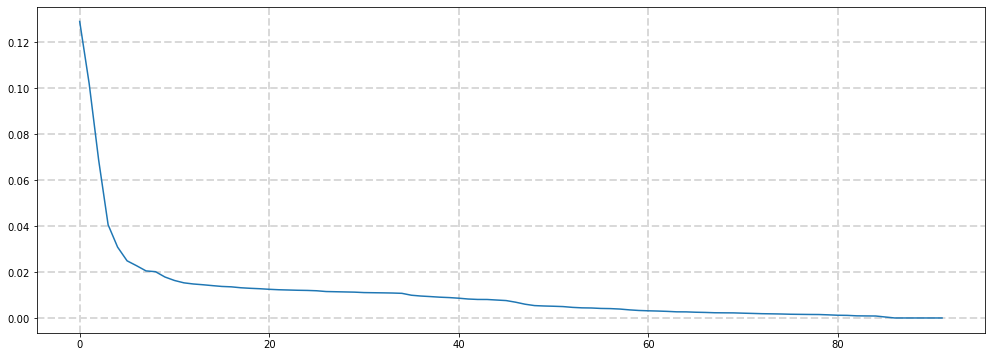

In [60]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(17,6))
plt.grid(True, lw = 2, ls = '--', c = '.85')
plt.plot(pca.explained_variance_ratio_)

### Comment
<span style="color:blue">By doing an inspection on the plot based on the explained variance ratio it seems that there are some features that dominate the variance. I need to look into more details to discover the dominant features and for that in the course we implemented a function to plot the components. This will be implemented in the next rows</span>

In [61]:
# Scree_plot implemented based on Udacity defined function in the lecture
def scree_plot(pca, annotate=False, limit=None, figsize=(22,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

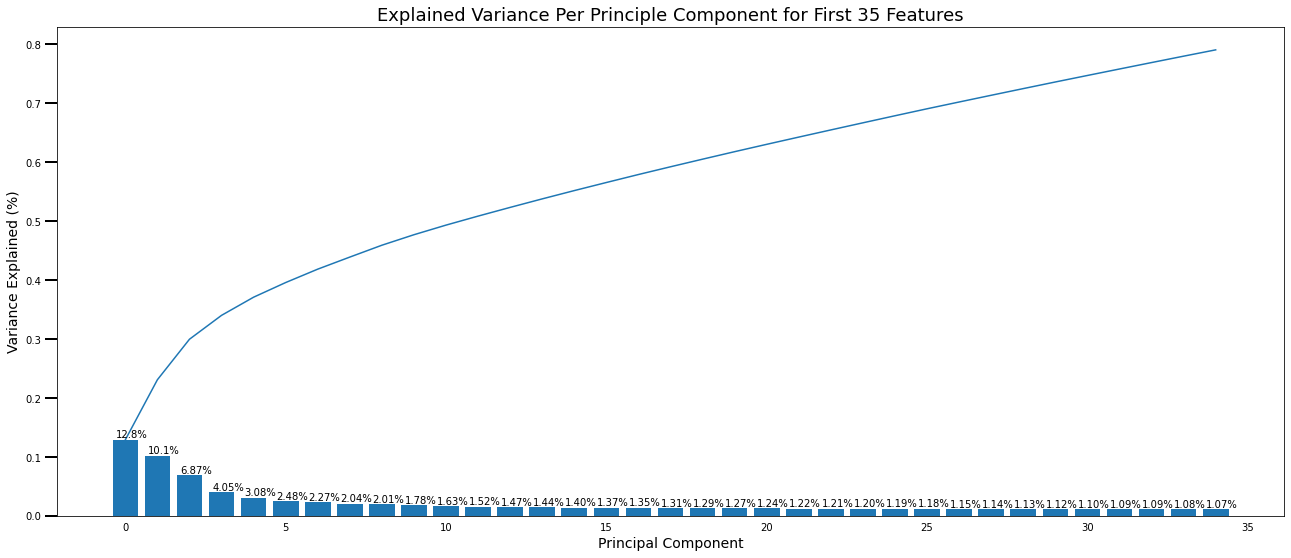

In [62]:
scree_plot(pca, annotate=True, limit=35)

### Comment
<span style="color:blue">Based on the plot we can see the impact of the first 5-4 components that dominate the variance explained by around ~40%</span>

In [63]:
# Variance explained by the 5 principal components
print("Variance explained % of the 5 principal components ", pca.explained_variance_ratio_[:5].sum())

Variance explained % of the 5 principal components  0.3710283821590218


Text(0, 0.5, 'Variance explained %')

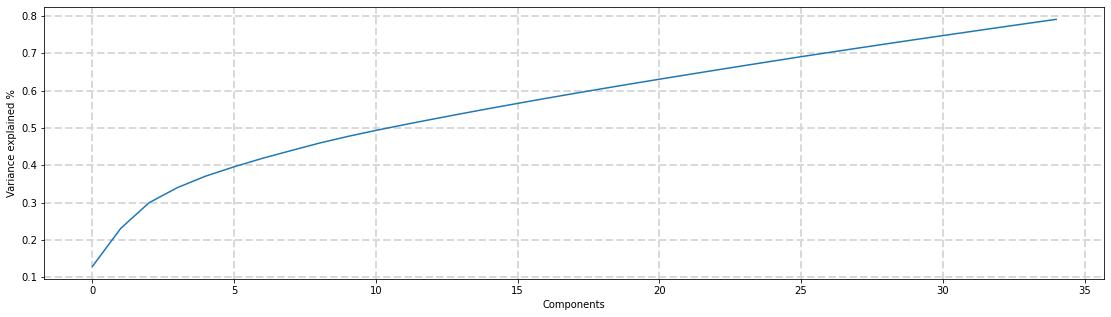

In [64]:
cummulative_values = []
for i in np.arange(1, 80, 1):
    cummulative_values.append(pca.explained_variance_ratio_[:i].sum())

plt.figure(figsize=(19,5))
plt.plot(cummulative_values[:35])
plt.grid(True, lw = 2, ls = '--', c = '.85')
plt.xlabel("Components")
plt.ylabel("Variance explained %")

### Comment
<span style="color:blue">By observing the plot based on the cummulative values for the variance. We can see barely that between 15 to 20 components, we account for the 60% of the variance explained, which is quite good. However, I will compare the contribution of the first 25 components agains the last 20 components </span>

In [65]:
pca.explained_variance_ratio_[:25].sum() - pca.explained_variance_ratio_[:20].sum()

0.0609619504006903

In [66]:
pca.explained_variance_ratio_[:20].sum() - pca.explained_variance_ratio_[:15].sum()

0.06603857498690757

### Comment
<span style="color:blue">Based on the previous comparisons, the contribution of the first 20 - 25 components are enough to keep all the information of the dataset. Therefore, 20 components would be enough to be used only on the PCA to keep most of the information of the dataset.  </span>

In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_20 = PCA(n_components=20)
x_pca_20 = pca_20.fit_transform(azdias_features_scaled)

In [68]:
# For plotting Purposes
pca_2 = PCA(n_components=2)
x_pca_2 = pca_2.fit_transform(azdias_features_scaled)

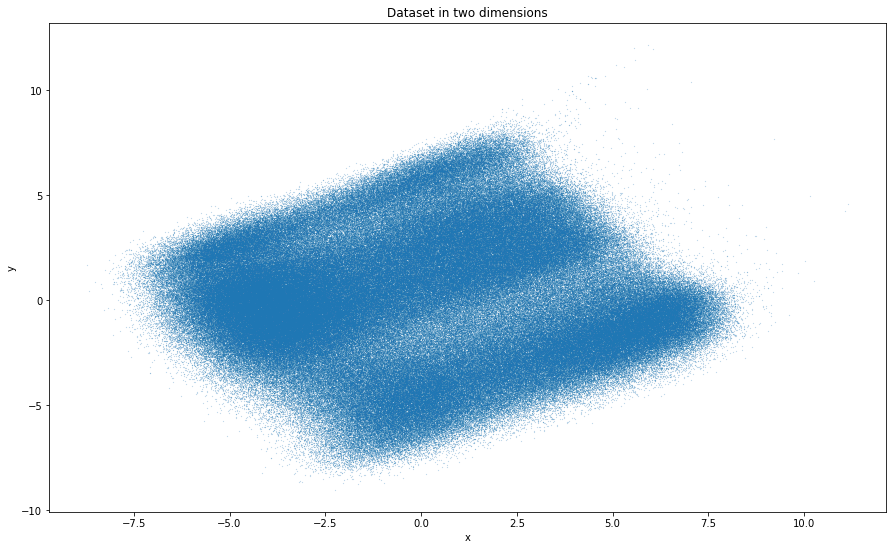

In [69]:
#Plot the dataset
plt.figure(figsize=(15,9))
plt.scatter(x_pca_2[:,[0][0]], x_pca_2[:,[1][0]], s=0.01)
plt.title('Dataset in two dimensions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Comment
<span style="color:blue">By ploting the dataset in two dimensions, it is not evident to see the data clusters, we will have to use the elbow method later to decide the amount of clusters. </span>

### Discussion 2.2: Perform Dimensionality Reduction

<span style="color:blue">As it was discussing during the section, 20 principal components are enough to cover more than 60% of the variance explained and it contains most of the information. I also analysed the marginal changes by adding one component by component and we see that after 20 components, the marginal contribution is around 1% per component. I also evaluated the contribution of the last 30 components and they contribute basically only 6%. Then it makes sense to keep only the first 20 or maximum 25 components. </span>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [70]:
# Implement collection of results based on Udacity course lectures
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= full_dataset.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)

In [71]:
results = pca_results(azdias_few_missing, pca_20)
results.head(5)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP
Dimension 1,0.1290,-0.1584,-0.0077,-0.2196,0.1753,-0.1461,0.0985,0.1051,0.1319,-0.1132,...,0.0158,-0.0059,0.0340,0.0762,-0.0860,0.0714,0.0433,-0.1132,-0.1860,-0.1227
Dimension 2,0.1019,0.2263,0.0741,0.0252,-0.1998,0.1981,-0.1857,-0.2037,0.1396,-0.0412,...,-0.0734,0.0060,-0.0063,-0.0253,0.0571,-0.0372,-0.0432,-0.0412,-0.1062,-0.0263
Dimension 3,0.0687,0.0663,-0.3695,0.1499,-0.0863,0.0837,-0.1750,-0.0780,-0.0518,0.0491,...,-0.0372,0.0023,-0.0076,-0.0205,0.0087,0.0199,-0.0424,0.0491,-0.0215,-0.0095
Dimension 4,0.0405,-0.0241,0.0372,0.0537,-0.0084,-0.0069,-0.1213,0.0624,-0.0866,0.3490,...,0.0161,0.0466,-0.0133,-0.1063,-0.0090,0.0127,-0.0027,0.3490,0.0992,0.0524
Dimension 5,0.0308,0.0572,-0.0127,0.0377,-0.0131,0.0058,0.0743,-0.0912,-0.0207,-0.0992,...,0.1270,-0.0076,0.0282,-0.0746,-0.0080,0.0184,-0.0125,-0.0992,-0.0849,-0.0346


### Comment

<span style="color:blue"> The previous table shown the first 5 high dimensions out of the 20 that we selected for our dataset. In the next cells I will provide some impressions based on the high negatives or high positive attributes in each dimension. </span>

In [72]:
# Implement print-out of higher weighted features
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

### Analyse the first 3 dimensions.

In [73]:
weighted_features(results, 'Dimension 1')

High Positive
 PLZ8_ANTG3            0.1976
PLZ8_ANTG4            0.1923
HH_EINKOMMEN_SCORE    0.1890
FINANZ_SPARER         0.1753
ORTSGR_KLS9           0.1692
EWDICHTE              0.1664
Name: Dimension 1, dtype: float64

High Negative
 FINANZ_MINIMALIST      -0.2196
MOBI_REGIO             -0.2188
KBA05_ANTG1            -0.2052
PLZ8_ANTG1             -0.1999
KBA05_GBZ              -0.1940
WEALTH                 -0.1860
ALTERSKATEGORIE_GROB   -0.1584
PLZ8_GBZ               -0.1503
Name: Dimension 1, dtype: float64


In [74]:
weighted_features(results, 'Dimension 2')

High Positive
 ALTERSKATEGORIE_GROB    0.2263
SEMIO_ERL               0.2004
FINANZ_VORSORGER        0.1981
RETOURTYP_BK_S          0.1565
SEMIO_LUST              0.1560
Name: Dimension 2, dtype: float64

High Negative
 SEMIO_REL               -0.2272
DECADE                  -0.2242
SEMIO_PFLICHT           -0.2081
FINANZ_UNAUFFAELLIGER   -0.2037
SEMIO_TRADV             -0.2018
FINANZ_SPARER           -0.1998
SEMIO_KULT              -0.1882
FINANZ_ANLEGER          -0.1857
ONLINE_AFFINITAET       -0.1736
SEMIO_RAT               -0.1516
Name: Dimension 2, dtype: float64


In [75]:
weighted_features(results, 'Dimension 3')

High Positive
 SEMIO_VERT    0.3484
SEMIO_SOZ     0.2671
SEMIO_FAM     0.2600
SEMIO_KULT    0.2424
Name: Dimension 3, dtype: float64

High Negative
 ANREDE_KZ        -0.3695
SEMIO_KAEM       -0.3404
SEMIO_DOM        -0.3140
SEMIO_KRIT       -0.2725
SEMIO_RAT        -0.2064
SEMIO_ERL        -0.1823
FINANZ_ANLEGER   -0.1750
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

<span style="color:blue"> For each dimension we proceed to discuss the tendencies based on the descriptions of the data dictionary.</span>

#### Dimension 1

##### High Positive

* PLZ8_ANTG3 (no 6-10 family homes)
* PLZ8_ANTG4 (no 10+ family homes)
* HH_EINKOMMEN_SCORE (highest income)

##### High Negative

* FINANZ_MINIMALIST (low financial interest) (Very low)
* MOBI_REGIO (very low movement)(displacement)
* KBA05_ANTG1 (very high share of 1-2 family homes)

<span style="color:blue"> The first customer may have a high income and lives in a house, most of the components indicate that. In addition, the customer does not move too much, which may indicate that the person is old or has a physical problem. </span>

#### Dimension 2

##### High Positive

* ALTERSKATEGORIE_GROB (< 30 years old)  
* SEMIO_ERL (event-oriented)               
* FINANZ_VORSORGER (be prepared - medium risk)       

##### High Negative

* SEMIO_REL (Not so religious)               
* DECADE           
* SEMIO_PFLICHT  (Dutiful)         

<span style="color:blue"> The person is young adult prepared to take risks and no religious and focus to do stuff </span>


#### Dimension 3

##### High Positive

* SEMIO_VERT (dreamful)    
* SEMIO_SOZ (socially-minded)    
* SEMIO_FAM   (family-minded)  

##### High Negative

* ANREDE_KZ (female)      
* SEMIO_KAEM (low combative attitude)     
* SEMIO_DOM (low dominant-minded)      

<span style="color:blue"> This customer is open, social and generous lady, who is not dominat and combative </span>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
#defining function that was given during the course.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) #absolute value taken
    
    return score

K= 1 Score -->  34866171.57437407
K= 2 Score -->  29494663.2711342
K= 3 Score -->  26490264.337928344
K= 4 Score -->  24796550.811463535
K= 5 Score -->  23643003.403306365
K= 6 Score -->  22581924.134681053
K= 7 Score -->  21686775.797898836
K= 8 Score -->  20972152.61218362
K= 9 Score -->  20523742.439413164
K= 10 Score -->  20084278.321241733
K= 11 Score -->  19754356.552423097
K= 12 Score -->  19454014.162304908
K= 13 Score -->  19175175.92116768
K= 14 Score -->  18897734.42323808
K= 15 Score -->  18661316.457111903
K= 16 Score -->  18379577.58064246
K= 17 Score -->  18152602.69345428
K= 18 Score -->  18037828.809476435
K= 19 Score -->  17800196.569884777


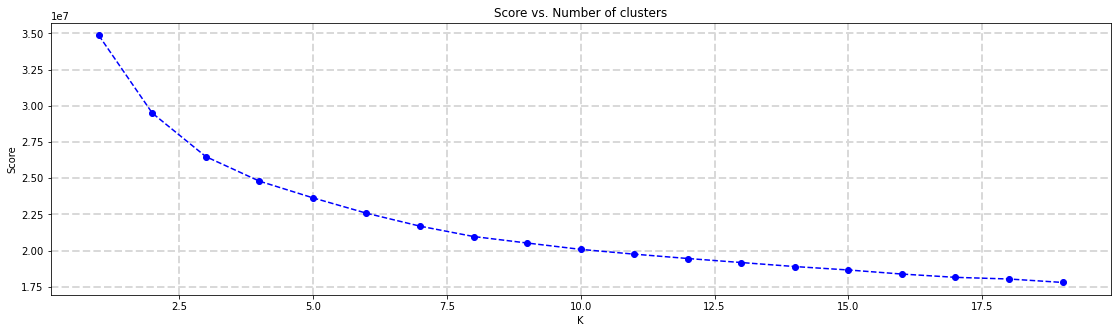

In [77]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,20))

for center in centers:
    score = get_kmeans_score(x_pca_20, center)
    print("K=", center ,"Score --> ", score)
    scores.append(score)

# Plot the elbow
plt.figure(figsize=(19,5))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.grid(True, lw = 2, ls = '--', c = '.85');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');

In [78]:
# Follow the recomendation to compute at least 8 clusters
kmeans_8 = KMeans(n_clusters=8).fit(x_pca_20)

### Discussion 3.1: Apply Clustering to General Population

<span style="color:blue"> Based on the elbow method and the score. The elbow or abrupt change does not show clearly on the plot but looking at the values and their marginal contribution by adding one more cluster in each iteration. We observe that the elbow is between 8 and 9 clusters. In favour of less clusters, I choose 8 clusters.  </span>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
udacity_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [80]:
# An example of the dataset
udacity_customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [81]:
# Cleaning the data
udacity_customers_copy = udacity_customers.copy()
udacity_customers_clean = data_preprocessing(udacity_customers_copy)

In [82]:
udacity_customers_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP,complete
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,1,3,True
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,3,4,True
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,4,1,True
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1,3,4,True
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1,2,3,True


In [83]:
# Dataset reduction statistics

print("The total amount of the Udacity Customers rows are",udacity_customers.shape[0],
      " and the amount of rows after cleaning the dataset is ", udacity_customers_clean.shape[0],
"This represents a reduction of rows in ", udacity_customers_clean.shape[0]/udacity_customers.shape[0] ,"%",
     "or ", udacity_customers.shape[0]-udacity_customers_clean.shape[0], " less rows")

The total amount of the Udacity Customers rows are 191652  and the amount of rows after cleaning the dataset is  115643 This represents a reduction of rows in  0.603400955899234 % or  76009  less rows


In [84]:
# Impute means
udacity_customers_imputed = imputer.transform(udacity_customers_clean)
# Standardize
udacity_customers_standard = scaler.transform(udacity_customers_imputed)
# Clustered 
udacity_customers_pca = pca_20.transform(udacity_customers_standard)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [85]:
# First we predict the labels for both datasets
azdias_predict = pd.DataFrame(np.array(kmeans_8.predict(x_pca_20)), columns=['Predictions'])
udacity_customer_predict = pd.DataFrame(np.array(kmeans_8.predict(udacity_customers_pca)), columns=['Predictions'])

### Comment
<span style="color:blue"> This will help us to compare later both prediction results.  </span>

In [86]:
# Create value counts
azdias_prop = azdias_predict.groupby('Predictions').size()
udacity_customer_prop = udacity_customer_predict.groupby('Predictions').size()

In [87]:
print(udacity_customer_prop, azdias_prop)

Predictions
0     8653
1    10376
2    25280
3    62190
4     1028
5     2437
6     4515
7     1164
dtype: int64 Predictions
0     90319
1     87652
2    100408
3    101431
4     63522
5     64368
6     57669
7     57840
dtype: int64


In [88]:
# Calculate missing proportions
azdias_miss_proportion = pd.Series(azdias.shape[0] - azdias_few_missing.shape[0])
udacity_customer_miss_proportion = pd.Series(udacity_customers.shape[0] - udacity_customers_clean.shape[0])

In [89]:
# Append on to arrays
azdias_prop = azdias_prop.append(azdias_miss_proportion)
udacity_customer_prop = udacity_customer_prop.append(udacity_customer_miss_proportion)
print("The miss proportion in Azdias is",azdias_miss_proportion[0])
print("The miss proportion in Udacity customer is",udacity_customer_miss_proportion[0])

The miss proportion in Azdias is 268012
The miss proportion in Udacity customer is 76009


/var/folders/g5/ky6bmjt90kqbsypch2rdmgf00000gp/T/ipykernel_72226/779543423.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  azdias_prop = azdias_prop.append(azdias_miss_proportion)
/var/folders/g5/ky6bmjt90kqbsypch2rdmgf00000gp/T/ipykernel_72226/779543423.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  udacity_customer_prop = udacity_customer_prop.append(udacity_customer_miss_proportion)


In [90]:
azdias_prop.index = range(9)
udacity_customer_prop.index = range(9)

In [91]:
azdias_prop = (azdias_prop/azdias_prop.sum()).reset_index()
udacity_customer_prop = (udacity_customer_prop/udacity_customer_prop.sum()).reset_index()

In [92]:
azdias_prop['source'] = 'population'
udacity_customer_prop['source'] = 'customers'
azdias_prop.columns = ['cluster', 'proportion', 'source']
udacity_customer_prop.columns = ['cluster', 'proportion', 'source']

In [93]:
predictions = pd.concat([azdias_prop, udacity_customer_prop])
predictions

,cluster,proportion,source
0,0,0.101343,population
1,1,0.098350,population
2,2,0.112663,population
3,3,0.113811,population
4,4,0.071275,population
5,5,0.072225,population
6,6,0.064708,population
7,7,0.064900,population
8,8,0.300725,population
0,0,0.045150,customers


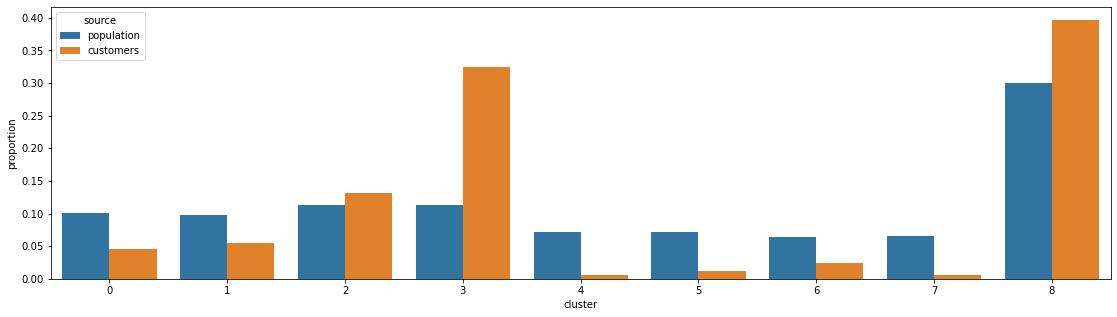

In [94]:
# Comparing the proportion of data in each cluster for the udacity customer data and for the general population.
ax=plt.figure(figsize=(19,5))
ax=sns.barplot(x='cluster', y='proportion', hue='source', data=predictions);

### Comment
<span style="color:blue"> Based on the results the labels that are overrepresented in the udacity customer data compared with the population data are 3, 8.  
On the otherhand the underrepresented are the rest of the columns.</span>

In [95]:
# We join customer pca details with the predictions
customer_labels = pd.merge(left=pd.DataFrame(udacity_customers_pca), right=udacity_customer_predict, left_index=True, right_index=True)
customer_labels.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Predictions
0,-4.846478,-0.498168,3.860678,0.774570,-3.684407,1.919835,0.856085,1.673967,2.000308,2.346770,...,-1.390381,-0.570418,-2.049329,2.060540,-0.329766,-0.538918,-0.312020,1.377354,1.182897,3
1,-2.451404,3.355678,-1.103115,3.622159,-0.728496,-1.509231,-0.685721,3.050178,0.875487,1.311486,...,-2.759731,-1.095129,-0.891380,0.418773,-1.030379,-0.284344,0.127287,0.525938,1.664608,2
2,0.555934,-1.849938,1.442117,3.307185,1.318846,1.073928,-1.943871,0.267130,0.061525,1.838834,...,-2.645339,-1.100915,-0.356785,-1.184689,-0.150534,0.601767,-1.630212,-1.057416,1.081930,6
3,-2.301181,0.123627,2.754598,3.482647,-3.199007,1.214040,-1.051541,2.512787,0.174878,1.896510,...,0.670282,-1.391691,-1.812159,-1.941883,-0.828018,-0.019249,-1.172312,1.332659,0.527394,3
4,-5.004878,-1.053483,2.562748,0.871643,-2.467711,1.480705,0.736968,2.281504,1.636736,1.335504,...,-1.481713,-0.427446,-1.658414,0.469437,0.167139,-0.253524,-0.780115,0.904742,3.167095,3
5,-4.295241,0.369387,4.120911,1.336533,-2.198591,-1.618390,0.643591,2.054730,3.453737,2.192079,...,-1.910372,-1.053341,-2.158234,0.609120,-0.646913,-0.459244,0.284511,1.746170,1.462813,3
6,-3.437933,-2.586326,1.409504,3.594996,-0.020014,1.662434,-1.436867,2.028466,0.119289,2.357578,...,-0.104660,0.438607,-1.046868,-0.358341,-0.474925,-0.448438,-1.402289,1.069368,3.180178,3
7,-4.390361,-1.968638,3.258156,1.789730,-2.709969,-1.174846,2.116743,2.346086,3.550493,1.454066,...,-2.827571,0.228994,-1.400956,-0.661824,-1.277297,-0.721658,-1.168081,-0.250959,1.391411,3
8,-4.692909,-3.430088,1.752491,-1.196380,0.641321,2.229856,0.902569,0.277668,-0.508714,1.783732,...,-2.709642,-0.015392,-0.497609,1.452909,-1.359105,-0.183452,-1.223384,2.707697,3.314500,3
9,0.061129,5.466900,-0.123362,5.016716,-1.225968,0.264348,-1.208728,0.410524,0.642025,1.214796,...,-1.879943,1.484899,-1.155520,-0.951497,0.107862,-1.478019,-0.843213,0.783506,2.632083,0


### Overrepresented - Cluster 8

In [96]:
over_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 3').drop('Predictions', axis=1))
over_regular = scaler.inverse_transform(over_transform)
over_df = pd.DataFrame(over_regular, columns=udacity_customers_clean.columns)

### Comment

<span style="color:blue"> We use the inverse transform msethod of the PCA and scaler objects to transform centroids back to the original data space and interpret the retrieved values directly.</span>



In [97]:
# The first 35 attributes
pd.DataFrame({'Attribute':over_df.mean()[:35].index,
              'values':over_df.mean()[:35].values}).sort_values(by=['values'], ascending=False).transpose()

,10,32,16,17,12,2,13,19,18,4,...,7,3,27,5,1,8,26,29,34,33
Attribute,DECADE,WOHNDAUER_2008,SEMIO_VERT,SEMIO_LUST,SEMIO_SOZ,FINANZ_MINIMALIST,SEMIO_FAM,SEMIO_KULT,SEMIO_ERL,FINANZ_VORSORGER,...,FINANZ_HAUSBAUER,FINANZ_SPARER,VERS_TYP,FINANZ_ANLEGER,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_TITEL,ANZ_HH_TITEL,ANZ_HAUSHALTE_AKTIV
values,1963.444288,8.572174,6.272675,5.773946,5.219068,5.148665,4.764979,4.614056,4.334056,4.322148,...,1.648229,1.452768,1.412355,1.246085,1.055775,0.949718,0.050684,0.008086,-0.069897,-0.883693


In [98]:
# The last 35 attributes
pd.DataFrame({'Attribute':over_df.mean()[35:].index,
              'values':over_df.mean()[35:].values}).sort_values(by=['values'], ascending=False).transpose()

,1,17,25,11,14,8,9,23,10,22,...,35,44,39,7,40,30,43,48,49,6
Attribute,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ORTSGR_KLS9,INNENSTADT,MOBI_REGIO,KBA05_GBZ,BALLRAUM,PLZ8_GBZ,EWDICHTE,PLZ8_HHZ,...,LP_FAMILIE_GROB_3,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_2,KBA05_ANTG4,GFK_URLAUBERTYP_3,CJT_GESAMTTYP_4,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,KBA05_ANTG3
values,1992.934444,706.445245,5.195364,4.680285,4.512376,4.51114,4.098,3.896781,3.891837,3.797539,...,0.09401,0.07602,0.054219,0.032063,0.024392,0.000489,-0.015191,-0.124761,-0.18153,-0.375594


### Underrepresented - Cluster 0

In [99]:
under_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 1').drop('Predictions', axis=1))
under_regular = scaler.inverse_transform(under_transform)
under_df = pd.DataFrame(under_regular, columns=udacity_customers_clean.columns)

In [100]:
# The first 35 attributes
pd.DataFrame({'Attribute':under_df.mean()[:35].index,
              'values':under_df.mean()[:35].values}).sort_values(by=['values'], ascending=False).transpose()

,10,33,32,16,17,12,13,19,31,4,...,9,3,28,27,1,8,5,34,26,29
Attribute,DECADE,ANZ_HAUSHALTE_AKTIV,WOHNDAUER_2008,SEMIO_VERT,SEMIO_LUST,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,W_KEIT_KIND_HH,FINANZ_VORSORGER,...,HEALTH_TYP,FINANZ_SPARER,ANZ_PERSONEN,VERS_TYP,ANREDE_KZ,GREEN_AVANTGARDE,FINANZ_ANLEGER,ANZ_HH_TITEL,SOHO_KZ,ANZ_TITEL
values,1963.182168,12.110643,8.206223,6.296103,5.765086,5.75967,5.0665,4.549131,4.336467,4.262578,...,1.740307,1.70953,1.597069,1.504747,1.055312,1.024893,0.683994,0.082608,0.042237,0.01492


In [101]:
# The last 35 attributes
pd.DataFrame({'Attribute':under_df.mean()[35:].index,
              'values':under_df.mean()[35:].values}).sort_values(by=['values'], ascending=False).transpose()

,1,17,25,10,26,22,24,19,12,8,...,42,31,38,44,30,48,40,43,39,49
Attribute,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ORTSGR_KLS9,EWDICHTE,RELAT_AB,PLZ8_HHZ,ARBEIT,PLZ8_ANTG2,GEBAEUDETYP_RASTER,KBA05_GBZ,...,GFK_URLAUBERTYP_5,CJT_GESAMTTYP_5,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_7,CJT_GESAMTTYP_4,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_12
values,1992.152751,512.248571,8.484932,6.340354,4.265023,3.978155,3.784256,3.563636,3.050249,2.805967,...,0.132161,0.116746,0.056516,0.041982,0.019865,0.000655,-0.023221,-0.027782,-0.036159,-0.162714


### Discussion 3.3: Compare Customer Data to Demographics Data


<span style="color:blue">Firstly, It is important to understand the customers profiles based on the Cluster 8 (overrepresented) and Cluster 0 (underrepresented) as dominant examples. </span>

#### Cluster 8

<span style="color:blue">Based on the most representative attributes, which are: </span>
	
* DECADE (1963)
* SEMIO_VERT (dreamful)
* SEMIO_SOZ (social minded)
* SEMIO_LUST (sensual-minded)
* FINANZ_MINIMALIST(low interest)
* SEMIO_FAM (family-minded)
* WOHNDAUER_2008


<span style="color:blue">This cluster basically has ederly people, who are dreamful, social with low financial interest, family focused. They live in the center of the city in community </span>

#### Cluster 0

<span style="color:blue">Based on the most representative attributes, which are: </span>

* DECADE (1984)
* SEMIO_PFLICHT (dutiful)
* SEMIO_DOM (dominant-minded)
* SEMIO_KAEM (combative attitude)
* SEMIO_RAT (rational)
* SEMIO_KRIT (critical-minded)
* MIN_GEBAEUDEJAHR (1993)
* KBA13_ANZAHL_PKW (Number of cars)

<span style="color:blue">This cluster basically has adult people around 36 years, who are  </span>
dutiful, dominant-minded, combative attitude, rational, critical minded. These customers may not be married since
social part is not dominant.

#### Considerations

<span style="color:blue">Secondly, based on these analysis of two clusters, similar analysis can be done based on the characteristics of all the clusters in order to obtain with more granularity the profile of the customer users. </span>

#### Conclusions

<span style="color:blue">Finally, if we use the two clusters we can see that for the people from Cluster 8. They are the ideal customers for  mail-order company, they are mostly in their period of life to enjoy time with all the family and are super social, which is great to talk about their mail-orders or catalogs sent by the company.   </span>

<span style="color:blue">On the other hand, we have the clients in cluster 0, which are unrepresented by the mail-order company since these are most probably living with a partner or alone without children, individualistic and rational minded. This means that mail-order is only one possibility out of all the online options that they can look. In addition, their age implies that they are more used to the e-commerce, rather than mail-orders purchases or receiving catalogs. </span>

<span style="color:blue">I would definetively recommend the mail-order company to target the Cluster 8 Customers.  </span>


<span style="color:red">Final Note: If the notebook is re-run, the clustering algorithm will put the centroids and it will change the distribution of the clusters. (One of the dissadvantages of KMeans.) </span>



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.